# Soal

Dengan data yang tiga kluster kemarin, Anda lakukan DBSCAN dengan nilai
$\epsilon = 5$ dan $\text{MinPTS}=3$. Hitung juga nilai Silhouette, Dunn, dan DB
index-nya.


In [1]:
data = [
    [10, 6],
    [9, 4],
    [2, 5],
    [2, 2],
    [15, 10],
    [20, 10],
    [18, 10],
    [17, 8],
    [8, 8],
    [17, 12],
    [3, 4],
    [7, 6],
]

eps = 5
min_pts = 3


# Jawaban

## Library and Utility Functions


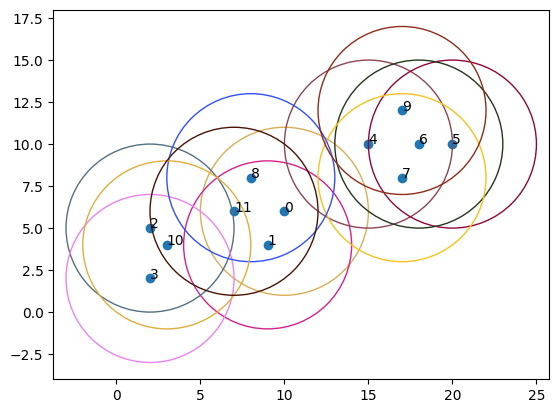

In [2]:
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt


def euclidean_dist(p0, p1):
    return np.sqrt((p0[0] - p1[0]) ** 2 + (p0[1] - p1[1]) ** 2)


def calc_centroid(*points):
    x_sum = 0
    y_sum = 0
    for p in points:
        x_sum += p[0]
        y_sum += p[1]
    return (x_sum / len(points)), (y_sum / len(points))


def build_dist_mat(data):
    dist_mat = {}
    for i, j in itertools.product(range(len(data)), repeat=2):
        dist_mat[i, j] = euclidean_dist(data[i], data[j])
    return dist_mat


def get_neighbours(dist_mat, p_i, eps):
    neighbours = []
    for (i, j), dist in dist_mat.items():
        if i == p_i and dist < eps:
            neighbours.append(j)
    return neighbours


def count_neighbours(dist_mat, p_i, eps):  # including the point itself
    return len(get_neighbours(dist_mat, p_i, eps))


def find_cluster_index(clusters, p_i):
    for c_i, cluster in enumerate(clusters):
        if cluster.issuperset({p_i}):
            return c_i
    raise ValueError("cant determine cluster index")


def plot_clusters(*series, label_data=None, circle_r=None):
    for s in series:
        if not s:
            continue
        plt.scatter(*zip(*s))
        if circle_r is not None:
            for p in s:
                cir = plt.Circle(
                    p,
                    circle_r,
                    color=np.random.rand(
                        3,
                    ),
                    fill=False,
                )
                plt.gca().set_aspect("equal", adjustable="datalim")
                plt.gca().add_patch(cir)

    if label_data is not None:
        for i, p in enumerate(label_data):
            plt.annotate(i, p)

    plt.show()


def plot_clusters_by_index(data, *i_series, **kwargs):
    series = [[data[i] for i in s] for s in i_series]
    return plot_clusters(*series, **kwargs)


plot_clusters(data, label_data=data, circle_r=eps)


## DBSCAN


In [3]:
def DBSCAN(dist_mat, *, eps, min_pts, with_noise=True, verbose=False):
    data_i = [k[0] for k in dist_mat]

    def vprint(*args, **kwargs):
        if not verbose:
            return
        print(*args, **kwargs)

    def is_core(p_i):
        return count_neighbours(dist_mat, p_i, eps) >= min_pts

    def is_border(p_i):
        return 1 < count_neighbours(dist_mat, p_i, eps) < min_pts

    def is_noise(p_i):
        return count_neighbours(dist_mat, p_i, eps) == 1

    core_points = [i for i in data_i if is_core(i)]
    border_points = [i for i in data_i if is_border(i)]
    noise_points = [i for i in data_i if is_noise(i)]

    if verbose:
        vprint("Point types")
        plot_clusters_by_index(data, *[core_points, border_points, noise_points])

    clusters = []
    if with_noise and noise_points:
        clusters.append({*noise_points})
    vprint(f"initial clusters: {clusters}")
    not_visited_core = core_points.copy()

    def walk_core(p_i):
        cluster_set = set()

        def walk(p_i):
            vprint(f"walking on #{p_i}")
            vprint(not_visited_core)
            neighbours = get_neighbours(dist_mat, p_i, eps)
            for np_i in neighbours:
                if np_i in not_visited_core:
                    not_visited_core.remove(np_i)
                    walk(np_i)
                else:
                    vprint(f"added neighbour #{np_i} to cluster set")
                    cluster_set.add(np_i)

        walk(p_i)
        return cluster_set

    # for every neighbour of core points, form a cluster
    while not_visited_core:
        vprint("current clusters: {clusters}")
        clusters.append(walk_core(random.choice(not_visited_core)))

    return clusters


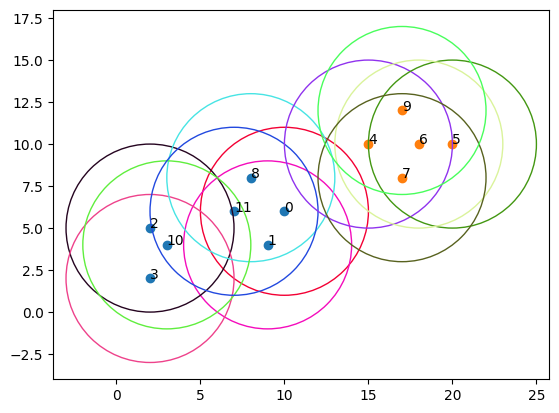

In [4]:
dist_mat = build_dist_mat(data)
clusters = DBSCAN(dist_mat, eps=eps, min_pts=min_pts, verbose=False)
plot_clusters_by_index(data, *clusters, circle_r=eps, label_data=data)

## Silhouette Coefficient


In [5]:
def silhouette_coef(dist_mat, clusters):
    # https://en.wikipedia.org/wiki/Silhouette_(clustering)

    def a(p_i):  # average intracluster distance
        cluster = clusters[find_cluster_index(clusters, p_i)]
        dist_sum = 0
        for p_j in cluster:
            if p_j == p_i:
                continue
            dist_sum += dist_mat[p_i, p_j]
        return dist_sum / (len(cluster) - 1)

    def b(p_i):  # average intercluster distance
        # find average distance to points in other clusters
        except_cluster_i = find_cluster_index(clusters, p_i)
        means = []
        for c_i, cluster in enumerate(clusters):
            if c_i == except_cluster_i:
                continue
            dist_sum = 0
            for p_j in cluster:
                dist_sum += dist_mat[p_i, p_j]
            means.append(dist_sum / len(cluster))
        return min(means)

    def s(p_i):
        cluster = clusters[find_cluster_index(clusters, p_i)]
        ai = a(p_i)
        bi = b(p_i)
        if len(cluster) == 1:
            return 0
        elif ai < bi:
            return 1 - ai / bi
        elif ai == bi:
            return 0
        else:
            return bi / ai - 1

    # indexes of data points from dist_mat
    data_i = [dist[0] for dist in dist_mat]
    return np.mean([s(p_i) for p_i in data_i])


In [11]:
silhouette_coef(dist_mat, clusters)

0.6493778413343179

## Davies-Bouldin Index (DB)


In [7]:
def db_index(data, clusters):
    # https://pyshark.com/davies-bouldin-index-for-k-means-clustering-evaluation-in-python/
    # with p = q = 2 (euclidean distance)

    def s(c_i):  # intracluster dispersion of cluster i
        cluster_points = [data[p_i] for p_i in clusters[c_i]]
        centroid = calc_centroid(*cluster_points)
        dist_sum = 0
        for p in cluster_points:
            dist_sum += euclidean_dist(p, centroid)
        return dist_sum / len(cluster_points)  # average dist

    def m(c_i, c_j):  # separation measure
        cluster_points_i = [data[p_i] for p_i in clusters[c_i]]
        cluster_points_j = [data[p_j] for p_j in clusters[c_j]]
        centroid_i = calc_centroid(*cluster_points_i)
        centroid_j = calc_centroid(*cluster_points_j)
        return euclidean_dist(centroid_i, centroid_j)

    def r(c_i, c_j):  # similarity between cluster
        return (s(c_i) + s(c_j)) / m(c_i, c_j)

    r_sum = 0
    for c_i in range(len(clusters)):
        r_sum += max(r(c_i, c_j) for c_j in range(len(clusters)) if c_i != c_j)
    return r_sum / len(clusters)


In [18]:
db_index(data, clusters)

0.4325360248855843

## Dunn Index (DI)


In [12]:
def dunn_index(dist_mat, clusters):
    # https://en.wikipedia.org/wiki/Dunn_index
    # Dunn version (intracluster is max two point, intercluster is min two point)

    def intracluster_dist(c_i):  # uppercase delta
        cluster = clusters[c_i]
        distances = []
        for p_i, p_j in itertools.combinations(cluster, r=2):
            distances.append(dist_mat[p_i, p_j])
        return max(distances)

    def intercluster_dist(c_i, c_j):  # lowercase delta
        cluster_i = clusters[c_i]
        cluster_j = clusters[c_j]
        distances = []
        for p_i, p_j in itertools.product(cluster_i, cluster_j):
            distances.append(dist_mat[p_i, p_j])
        return min(distances)

    max_intra_dist = max(intracluster_dist(c_i) for c_i in range(len(clusters)))
    min_inter_dist = min(
        intercluster_dist(c_i, c_j)
        for c_i, c_j in itertools.combinations(range(len(clusters)), r=2)
    )

    return min_inter_dist / max_intra_dist


In [14]:
dunn_index(dist_mat, clusters)

0.7158910531638176